# makemore: part 3

# Setup

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [4]:
# read in all the words
words = open('../data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [10]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11697


In [11]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

      0/ 200000: 27.8817
  10000/ 200000: 2.6227
  20000/ 200000: 2.4278
  30000/ 200000: 2.8950
  40000/ 200000: 2.1973
  50000/ 200000: 2.6945
  60000/ 200000: 2.4021
  70000/ 200000: 2.0127
  80000/ 200000: 2.3034
  90000/ 200000: 2.2562
 100000/ 200000: 2.0586
 110000/ 200000: 2.2819
 120000/ 200000: 1.9501
 130000/ 200000: 2.3891
 140000/ 200000: 2.2534
 150000/ 200000: 2.1645
 160000/ 200000: 1.9887
 170000/ 200000: 1.8092
 180000/ 200000: 2.0050
 190000/ 200000: 1.9099


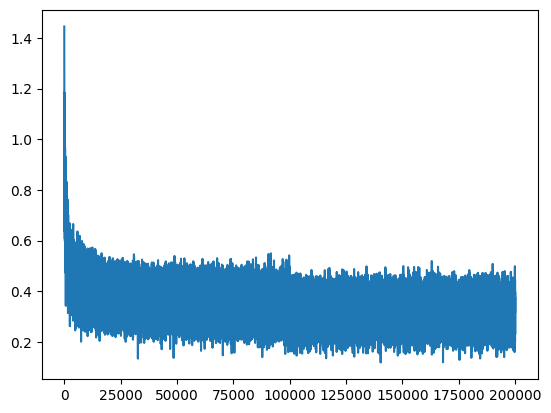

In [12]:
plt.plot(lossi)

In [15]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, y) # loss function
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1208510398864746
val 2.1610028743743896


# Initialization

The initial loss is way to high. Since the model does not know anything about character probabilities (and is initialized randomly), it should assign equal probability to each character.


## Logits


- Run Training loop, break after first iteration
  - Logits take on extreme values, resulting in high loss
- Scale down W2, set b2 to zero
  - output should be more uniform
- Run training with new initialization
  - actual optimization starts right away
  - loss should be better (because of more effective training steps)

## Tanh activations

### In last layer (h)

Lots of activations are $|1|$.
- Visualize by putting all activations into a histogram
- Do the same to hpreact (activations from first layer)
  - Should be much better shaped

Tanh of $|1|$ is problematic because it gives zero gradient, killing the backpropagation at this point.
Another visualization:
- Visualize booolean mask of h with cutoff at $.99$
  - imshow is white when True is plotted

### In first layer (hpreact) 

Values of hpreact are nicely centered around $0$, but their variance is too large. Fix that by adjusting the weights of W1 and b1 during initialization:

- multiply b1 by $0.01$, W1 by $0.1$ (then $0.2$)
- re-plot the histograms and 'qr code'
- re-run training (after fresh initialization)
  - should improve loss again